In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

# The Three-Body Problem
## Lecture 21

**Follows Giordano 4.4: The Three-Body Problem and the Effect of Jupiter on Earth**

Up to this point, we have only considered two-body solar systems.  The real solar system has multiple planets and this makes the an analytical theory much more difficult.

Numerically, we can tackle the problem by explicitly calculating the pairwise forces of gravity in a multiple planet solar system.  For concreteness, let's start with the three-body problem of an Sun-Earth-Jupiter system.  

Let's start by reproducing the simulation of the orbit of single planet around the sun.  This code solve for the orbit of a single planet (this time ignoring the effects of general relativity).  This is the same code as given in the previous lecture with the RK4 scheme set up more compactly.

In [2]:
π = np.pi

def orbit1(tmax = 1.0, dt = 0.001, v0 = 2*π, x0 = 1):
    """
    Calculate the orbit of planet
    """

    # number of timesteps
    N = round(tmax/dt)

    # allocate arrays
    x = np.zeros(N)
    y = np.zeros(N)
    vx = np.zeros(N)
    vy = np.zeros(N)
    t = np.zeros(N)
    
    # initialise position of planet in AU
    x[0] = x0
    y[0] = 0

    # initialise velocity of planet in AU/yr
    vx[0] = 0
    vy[0] = v0

    def F(q):
        x, y, vx, vy = q
        r = np.sqrt(x**2+y**2)
        dxdt = vx
        dydt = vy
        dvxdt = - (4*π**2*x)/(r**3)
        dvydt = - (4*π**2*y)/(r**3)
        
        dqdt = np.array([dxdt, dydt, dvxdt, dvydt])
        return dqdt
        
    # loop over the timesteps
    for i in range(N-1):
        t[i+1] = t[i] + dt
        
        # 4th order Runge-Kutta
        q0 = np.array([x[i], y[i], vx[i], vy[i]])
        s1 = F(q0)
        q1 = q0 + s1*dt/2
        s2 = F(q1)
        q2 = q0 + s2*dt/2
        s3 = F(q2)
        q3 = q0 + s3*dt
        s4 = F(q3)
        q4 = q0 + (s1 + 2*s2 + 2*s3 + s4)/6 * dt
        
        x[i+1], y[i+1], vx[i+1], vy[i+1] = q4
              
    return x, y, vx, vy, t

Our plotting tool to show the orbit

In [3]:
def plot_orbit(x, y, t, t0=None):
    "Make a plot of planet showing the Sun"
    
    # Plot the Sun at the origin
    plt.plot(0, 0, '.',color="yellow", markersize=20, markeredgecolor='black')
  
    plt.plot(x, y, 'k-', linewidth=0.5)
  
    # Plot the planet at a specific position
    if t0 is None:
        i = -1
    else:
        i = int(t0/t[-1]*len(t))
        if i >= len(t):
            i = len(t)-1
    plt.plot(x[i], y[i], '.', color= 'k', markersize=15)

    plt.xlabel('x (AU)')
    plt.ylabel('y (AU)')
    plt.axis('equal')

And the planetary data:

In [5]:
data = { 'Mercury' : {'name': 'Mercury', 'm':2.4e23, 'a':0.39,  'e':0.206},
         'Venus'   : {'name': 'Venus',   'm':4.9e24, 'a':0.72,  'e':0.007},   
         'Earth'   : {'name': 'Earth',   'm':6.0e24, 'a':1.00,  'e':0.017},  
         'Mars'    : {'name': 'Mars',    'm':6.6e23, 'a':1.52,  'e':0.093},
         'Jupiter' : {'name': 'Jupiter', 'm':1.9e27, 'a':5.20,  'e':0.048},
         'Saturn'  : {'name': 'Saturn',  'm':5.7e26, 'a':9.54,  'e':0.056},
         'Uranus'  : {'name': 'Uranus',  'm':8.8e25, 'a':19.19, 'e':0.046},
         'Neptune' : {'name': 'Neptune', 'm':1.03e26,'a':30.06, 'e':0.010},
         'Pluto'   : {'name': 'Pluto',   'm':1.3e22, 'a':39.53, 'e':0.248},
        }

## Example: Earth's orbit (two-body problem)

From conservation of energy and conservation of angular momentum, we can show that the initial velocity can be calculated as

$$ v_0 = \sqrt{G M_S \frac{1}{a} \frac{(1 - e)}{(1+e)} } $$

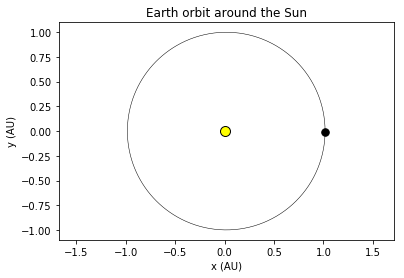

In [7]:
fig, axes = plt.subplots(figsize=(6, 4))
p = data['Earth']

x0 = (1+p['e'])*p['a']

## See equation (4.16) of Giordano, from conservation of energy and angular momentum
v0 = 2*π*np.sqrt(1/p['a']*(1-p['e'])/(1+p['e']))

x, y, vx, vy, t = orbit1(v0=v0, tmax = 1, x0 = x0)
plot_orbit(x,y,t)
plt.title('Earth orbit around the Sun')
plt.show()

## Extend to Three-Bodies

Our first goal will be to rewrite the above routines to that they support multiple planets.  In terms of forces we need to add in the additional force between, say, Earth and Jupiter

$$ F_{EJ} = \frac{G M_J M_E}{r_{EJ}^2} $$

Assuming the orbits are all coplanar, the components in the $xy$-plane are 

\begin{align}
F_{EJ,x} &= - \frac{G M_J M_E}{r_{EJ}^2} \cos \theta_{EJ} = - \frac{G M_J M_E( x_e - x_j)}{r_{EJ}^3} \\
F_{EJ,y} &= - \frac{G M_J M_E}{r_{EJ}^2} \sin \theta_{EJ} = - \frac{G M_J M_E( y_e - y_j)}{r_{EJ}^3} \\
\end{align}

The total force on Earth in the $x$-direction is the sum of the forces of gravity from the Sun and Jupiter. The equation of motion is of the form:

$$ \frac{d v_{x,e} }{dt} = - \frac{G M_S x_e}{r^3} - \frac{G M_J ( x_e - x_j)}{r_{EJ}^3}$$

Recall that we are using AU and yr as are units for distance and time, respectively.  In that system,  we have

$$ G M_S = 4 \pi^2\; \mathrm{AU}^3/\mathrm{yr}^2 $$

So we can calculate $G M_J$ as follows

$$ G M_J = G M_S \frac{M_J}{M_S} = 4\pi^2 \frac{M_J}{M_S} $$


### Many more variables

As soon as we start to deal with more than one planet, we will need many more variables to keep track of the entire system.  One approach is just to extend our code and use the arrays 

    x_E, y_E, vx_E, vy_E, x_J, y_J, vx_J, vy_J
    
where we track the position and velocity for both the Earth and Jupiter.  But this quickly will become cumbersome. With more than two planets, we would need even more variables.  

Let's create a new data structure that holds all of the information about each planet.



In [8]:
class Planet():
    def __init__(self, data, N):
        
        # initialize with given planetary data
        self.name = data['name']
        self.m = data['m'] ## mass
        self.e = data['e'] ## eccentricity
        self.a = data['a'] ## semimajor axis length
                
        # arrays for storage of 
        self.x = np.zeros(N)
        self.y = np.zeros(N)
        self.vx = np.zeros(N)
        self.vy = np.zeros(N)

        # calculate initial position and velocity
        self.x[0] = (1 + self.e)*self.a
        if self.a > 0:
            self.vy[0] = 2*π * np.sqrt(1/self.a * (1-self.e)/(1+self.e))
        else:
            self.vy[0] = 0
        

Here is how our `orbit()` function changes when written with this new data structure.

In [9]:
#Mass of the Sun in kg
M_s = 2e30

def orbit2(tmax = 1.0, dt = 0.001, planets=[]):
    """
    Calculate the orbit of a planet
    """

    # number of timesteps
    N = round(tmax/dt)
    t = np.zeros(N)

    # allocate planets
    p1 = Planet(planets[0], N)
    p2 = Planet(planets[1], N)

    def F(q):
        x1, y1, vx1, vy1, x2, y2, vx2, vy2 = q
        r1 = np.sqrt(x1**2+y1**2)
        r2 = np.sqrt(x2**2+y2**2)
        r12 = np.sqrt((x1-x2)**2+(y1-y2)**2)
        
        dxdt1 = vx1
        dydt1 = vy1
        dvxdt1 = - 4*π**2*x1/(r1**3) - 4*π**2*(p2.m/M_s)*(x1-x2)/(r12**3)
        dvydt1 = - 4*π**2*y1/(r1**3) - 4*π**2*(p2.m/M_s)*(y1-y2)/(r12**3)
        
        dxdt2 = vx2
        dydt2 = vy2
        dvxdt2 = - 4*π**2*x2/(r2**3) - 4*π**2*(p1.m/M_s)*(x2-x1)/(r12**3)
        dvydt2 = - 4*π**2*y2/(r2**3) - 4*π**2*(p1.m/M_s)*(y2-y1)/(r12**3)
        
        dqdt = np.array([dxdt1, dydt1, dvxdt1, dvydt1,
                         dxdt2, dydt2, dvxdt2, dvydt2])
                                          
        return dqdt
        
    # loop over the timesteps
    for i in range(N-1):
        t[i+1] = t[i] + dt
        
        q0 = np.array([p1.x[i], p1.y[i], p1.vx[i], p1.vy[i],
                       p2.x[i], p2.y[i], p2.vx[i], p2.vy[i]] )
        
        s1 = F(q0)
        q1 = q0 + s1*dt/2
        s2 = F(q1)
        q2 = q0 + s2*dt/2
        s3 = F(q2)
        q3 = q0 + s3*dt
        s4 = F(q3)
        q4 = q0 + (s1 + 2*s2 + 2*s3 + s4)/6 * dt
        
        (p1.x[i+1], p1.y[i+1], p1.vx[i+1], p1.vy[i+1], 
         p2.x[i+1], p2.y[i+1], p2.vx[i+1], p2.vy[i+1]) = q4
        
    return p1, p2, t

Notice that the Runge-Kutta scheme remains basically unchanged.  But our 'state space' now has 8 variables.

## Example with Earth-Jupiter-Sun system

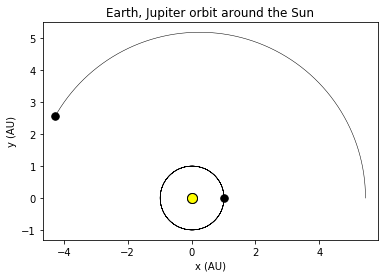

In [10]:
fig, axes = plt.subplots(figsize=(6, 4))

p1, p2, t = orbit2(tmax=5, 
                  planets=[data['Earth'], data['Jupiter']])

plot_orbit(p1.x, p1.y, t)
plot_orbit(p2.x, p2.y, t)
plt.axis('equal')

plt.title('Earth, Jupiter orbit around the Sun')
plt.show()

## Another option for animation

Let's build a little widget to explore how Earth and Jupiter move relative to each other.

In [11]:
from ipywidgets import interact

In [12]:
tmax = 12.0

p1, p2, t = orbit2(tmax=tmax,
                  planets=[data['Earth'], data['Jupiter']])

@interact(t0=(0, tmax))
def investigate_orbit(t0=0):
    plot_orbit(p1.x,p1.y, t, t0=t0)
    plot_orbit(p2.x,p2.y, t, t0=t0)
    plt.title('Earth, Jupiter orbit around the Sun')

interactive(children=(FloatSlider(value=0.0, description='t0', max=12.0), Output()), _dom_classes=('widget-int…

### Precession of Earth's Orbit due to a very large Jupiter

Now observe what happen if we increase the mass of Jupiter to 300 $M_J$

In [13]:
scale = 300
tmax = 4.0

jupiter = data['Jupiter']
big_jupiter = jupiter.copy()
big_jupiter['m'] = jupiter['m'] * scale

p1, p2, t = orbit2(tmax=tmax,
                  planets=[data['Earth'], big_jupiter])
    
@interact(t0=(0, tmax))
def investigate_orbit(t0=0):
    
    plot_orbit(p1.x,p1.y, t, t0=t0)
    plot_orbit(p2.x,p2.y, t, t0=t0)
            
    plt.suptitle("Effect of a very large Jupiter on Earth's orbit")

interactive(children=(FloatSlider(value=0.0, description='t0', max=4.0), Output()), _dom_classes=('widget-inte…

You should notice that the orbit is now precessing. 

We can explore how the mass of Jupiter changes the rate of the precession.

In [14]:
tmax = 5.0

@interact(scale=(0, 1000, 50))
def investigate_precession(scale=0):
    
    # solve for the orbits of Earth and a large Jupiter
    jupiter = data['Jupiter']
    big_jupiter = jupiter.copy()
    big_jupiter['m'] = jupiter['m'] * scale

    p1, p2, t = orbit2(tmax=tmax,
                  planets=[data['Earth'], big_jupiter])
    

    plot_orbit(p1.x, p1.y, t)
    plot_orbit(p2.x, p2.y, t)
    
    
    plt.suptitle("Effect of a large Jupiter on Earth's orbit")

interactive(children=(IntSlider(value=0, description='scale', max=1000, step=50), Output()), _dom_classes=('wi…

Notice that for very large Jupiters, the Earth's orbit is unstable.  At a mass of 1000 $M_J$, the Earth is actually ejected from the solar system. 

Note that, here, we are ignoring that fact that the Sun itself should really be moving, too.  

But first, let's see if we can get all of the planets into one simulation.  

In [15]:
#Mass of the Sun in kg
M_s = 2e30

def orbit3(tmax = 1.0, dt = 0.001, planets=[]):
    """
    Calculate the orbit of many planets
    """

    # number of timesteps
    N = round(tmax/dt)
    t = np.zeros(N)

    # allocate planets
    all_p = [Planet(data, N) for data in planets]
    # this creates a list of all the planets
    
    def F(q):
        dqdt = np.zeros(len(q))
        
        # for each planet
        for i in range(len(q)//4):
            x1, y1, vx1, vy1 = q[4*i:4*i+4]
            r1 = np.sqrt(x1**2+y1**2)
            dxdt = vx1
            dydt = vy1
            dvxdt = - 4*π**2*x1/(r1**3)
            dvydt = - 4*π**2*y1/(r1**3)
            
            # for each other planet
            for j in range(len(q)//4):
                if i==j:
                    continue
                x2, y2, vx2, vy2 = q[4*j:4*j+4]
                r12 = np.sqrt((x1-x2)**2+(y1-y2)**2)

                dvxdt += - 4*π**2*(all_p[j].m/M_s)*(x1-x2)/(r12**3)
                dvydt += - 4*π**2*(all_p[j].m/M_s)*(y1-y2)/(r12**3)
            
            dqdt[4*i:4*i+4] = [dxdt, dydt, dvxdt, dvydt]
                         
        return dqdt
        
    # loop over the timesteps
    for i in range(N-1):
        t[i+1] = t[i] + dt
        
        q0 = []
        for p in all_p:
            q0 += [p.x[i], p.y[i], p.vx[i], p.vy[i]]
        q0 = np.array(q0)
                    
        s1 = F(q0)
        q1 = q0 + s1*dt/2
        s2 = F(q1)
        q2 = q0 + s2*dt/2
        s3 = F(q2)
        q3 = q0 + s3*dt
        s4 = F(q3)
        q4 = q0 + (s1 + 2*s2 + 2*s3 + s4)/6 * dt
        
        for n, p in enumerate(all_p):
            p.x[i+1], p.y[i+1], p.vx[i+1], p.vy[i+1] = q4[4*n:4*n+4]
        
    return all_p, t

In [25]:
tmax = 6.0

p, t = orbit3(tmax=tmax,
            # planets=[data['Earth'], data['Jupiter'], data['Mars']]
            # planets=[data['Earth'], big_jupiter, data['Mars']]
            # planets=[p for p in data.values()]
             planets=[p for p in data.values() if p['a'] < 8]
             )

In [26]:
@interact(t0=(0, tmax, 0.1))
def investigate_orbit(t0=0):
    for p1 in p:
        plot_orbit(p1.x,p1.y, t, t0=t0)
    
    plt.title('Solar System')

interactive(children=(FloatSlider(value=0.0, description='t0', max=6.0), Output()), _dom_classes=('widget-inte…

## Three-Body Problem

In the most general case, the Sun itself would move do to the gravitational forces from the other planets.  Since the Sun is so much more massive than the other planets, it is reasonable to assume that the Sun does not itself move.

However, suppose we had a binary star system with two stars and a planet. Then all three bodies would be in motion. Let's rewrite our last route so that the Sun is no longer special but also interacts with all the other bodies in the solar system.

In [27]:
#Mass of the Sun in kg
M_s = 2e30

def orbit4(tmax = 1.0, dt = 0.001, bodies=[]):
    """
    Calculate the orbit of many planets
    """

    # number of timesteps
    N = round(tmax/dt)
    t = np.zeros(N)

    # allocate planets
    all_p = [Planet(data, N) for data in bodies]
    # this creates a list of all the planets
    
    def F(q):
        dqdt = np.zeros(len(q))
        
        # for each body in the system
        for i in range(len(q)//4):
            x1, y1, vx1, vy1 = q[4*i:4*i+4]
            r1 = np.sqrt(x1**2+y1**2)
            dxdt = vx1
            dydt = vy1
            dvxdt = 0
            dvydt = 0
            
            # for each other body
            for j in range(len(q)//4):
                if i==j:
                    continue
                x2, y2, vx2, vy2 = q[4*j:4*j+4]
                r12 = np.sqrt((x1-x2)**2+(y1-y2)**2)

                dvxdt += - 4*π**2*(all_p[j].m/M_s)*(x1-x2)/(r12**3)
                dvydt += - 4*π**2*(all_p[j].m/M_s)*(y1-y2)/(r12**3)
            
            dqdt[4*i:4*i+4] = [dxdt, dydt, dvxdt, dvydt]
                         
        return dqdt
        
    # loop over the timesteps
    for i in range(N-1):
        t[i+1] = t[i] + dt
        
        q0 = []
        for p in all_p:
            q0 += [p.x[i], p.y[i], p.vx[i], p.vy[i]]
        q0 = np.array(q0)
                    
        s1 = F(q0)
        q1 = q0 + s1*dt/2
        s2 = F(q1)
        q2 = q0 + s2*dt/2
        s3 = F(q2)
        q3 = q0 + s3*dt
        s4 = F(q3)
        q4 = q0 + (s1 + 2*s2 + 2*s3 + s4)/6 * dt
        
        for n, p in enumerate(all_p):
            p.x[i+1], p.y[i+1], p.vx[i+1], p.vy[i+1] = q4[4*n:4*n+4]
        
    return all_p, t

Add the Sun as an explicit member of the solar system.

In [28]:
data['Sun'] = { 'name' : 'Sun', 'm' : 2e30, 'a' : 0, 'e' : 0}
data['BigJupiter'] = { 'name' : 'BigJupiter', 'm' : 1.9e+27*200, 'a' : 5.2, 'e' : 0.048}


In [33]:
tmax = 2.0

p, t = orbit4(tmax=tmax,
              bodies=[data['Sun'], 
                      #data['Jupiter'],
                      data['BigJupiter'],  
                      data['Earth']
                     ]
             )

In [34]:
@interact(t0=(0, tmax, 0.1))
def investigate_orbit(t0=0):
    for p1 in p:
        plot_orbit(p1.x,p1.y, t, t0=t0)
    
    plt.title('Solar System')

interactive(children=(FloatSlider(value=0.0, description='t0', max=2.0), Output()), _dom_classes=('widget-inte…